#02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options). Spam or not spam, photos of steak, sushi, or pizza.

### 1. Make classification data and get it ready

In [36]:
import sklearn

In [37]:
# 1. This is to make some data with sklearn.datasets.
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles and added noise to so that the data isn't too perfect.
# Random state is to make sure that the data is reproducible.
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

In [38]:
# Checking length of X and y and type
len(X), len(y), type(X), type(y)

(1000, 1000, numpy.ndarray, numpy.ndarray)

In [39]:
# Visualize Visualize Visualize
print(f"First 5 samples of X:\n {X[:5]} and X's type is {type(X)}")
print(f"First 5 samples of y:\n {y[:5]} and y's type is {type(y)}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] and X's type is <class 'numpy.ndarray'>
First 5 samples of y:
 [1 1 1 1 0] and y's type is <class 'numpy.ndarray'>


In [40]:
# Make a dataframe with Panda
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [41]:
circles.label.value_counts() # Shows the number of instances of a label per class

label
1    500
0    500
Name: count, dtype: int64

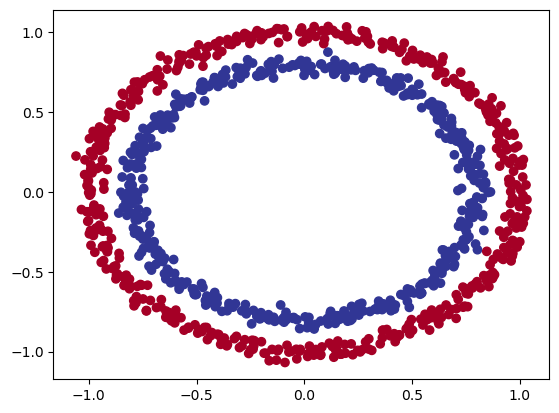

In [42]:
# Visualize Visualize Visualize with a graph instead of numbers in a table
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y, 
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

1.1 Check input and output shapes a lot of errors happen due to shapes.

In [43]:
X.shape, y.shape, type(X), type(y)

((1000, 2), (1000,), numpy.ndarray, numpy.ndarray)

In [45]:
# Convert NumPy arrays into tensors
X_sample = X[0]
y_sample = y[0]
print(f"Value for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Value for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn our data into tensors and create train and test splits

In [46]:
import torch
torch.__version__

'2.0.1'

In [47]:
# Convert NumPy arrays into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [48]:
# Split data into training and test sets 80% of data will be for training and 20% will be for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,#0.2 = 20% of data will be for test & 80% will be train
                                                    random_state=42 # random seed for reproducibility
                                                    )

In [49]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model
Let's build a model to classify our blue and red dots.
To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module` )
3. Define a loss function and optimizer
4. Creating a training and test loop

In [50]:
# Import Pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [51]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# Now we've setup device agnostic code, let's create a model that:

1. Subclasses nn.Module (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Defines a "forward()' method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target 'device'

In [52]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
        def __init__(self):
            super().__init__()
            #2. Create 2 nn.Linear layers capable of handling the shapes of our data
            self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features more features to learn
            self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

        # 3. Define a forward() method that outlines the forward pass
        def forward(self, x):
            return self.layer_2(self.layer_1(x)) # x-> layer_1 -> layer_2 -> output
        
    #4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [53]:
next(model_0.parameters()).device

device(type='cpu')

In [54]:
# Let's replicate the model above using nn.Sequential()
# It's an easier way of creating a Neural Network but not as flexible as subclassing nn.Module
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)
                        ).to(device) # Which in my case is cpu

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [55]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5377, -0.4538],
                      [-0.2479,  0.1072],
                      [-0.2061, -0.1474],
                      [-0.1293,  0.5296],
                      [-0.5764,  0.2504]])),
             ('0.bias', tensor([ 0.4263,  0.4242, -0.5631,  0.2238, -0.6877])),
             ('1.weight',
              tensor([[ 0.0774,  0.3499,  0.0839, -0.3856,  0.3256]])),
             ('1.bias', tensor([-0.0044]))])

In [56]:
# Make predictions with inference mode
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(
        f"Length of untrained preds samples:{len(untrained_preds)}, Shape: {untrained_preds.shape}"
    )
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of untrained preds samples:200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [57]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

###2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again.. this is problem specific.

For example for regression you might want MAE Or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)•

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use torch.nn.BCEWithLogitsLoss(), for more on what binary cross entropy (BCE) read an article about it.

For different optimizers see torch.optim



In [58]:
# Set up a loss function
# loss_fn = nn.BCELoss() # Binary Cross Entropy Loss = requires inputs to have gone through the sigmoid activation prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss() = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # Stochastic Gradient Descent

In [59]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5377, -0.4538],
                      [-0.2479,  0.1072],
                      [-0.2061, -0.1474],
                      [-0.1293,  0.5296],
                      [-0.5764,  0.2504]])),
             ('0.bias', tensor([ 0.4263,  0.4242, -0.5631,  0.2238, -0.6877])),
             ('1.weight',
              tensor([[ 0.0774,  0.3499,  0.0839, -0.3856,  0.3256]])),
             ('1.bias', tensor([-0.0044]))])

In [60]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right.

def accuracy_fn(y_true, y_pred):
    correct =  torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc



## 3. Train the model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits -> probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

Below are logits:

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax().


In [61]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [62]:
# View the first 5 outputs of the forward pass on test data

y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1647],
        [-0.3122],
        [ 0.0605],
        [-0.2278],
        [-0.1958]], grad_fn=<SliceBackward0>)

In [63]:
y_test[:5]


tensor([1., 0., 1., 0., 1.])

### 3.2 Build a training loop.

In [64]:
# Set for reproducibility
torch.manual_seed(42)

# Set the number of training epochs or training loops
epochs = 1000

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training Phase ###
    model_0.train()

    # 1. Forward pass with raw logits from the model
    y_logits = model_0(X_train).squeeze() # squeeze() removes any extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> prediction probability -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCEWithLogitsLoss expects raw logits as input e.g. y_logits    
    
    # 3. Calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 4. Optimizer zero grad also known as zero the gradients
    optimizer.zero_grad()

    # 5. Loss backwards backpropagation
    loss.backward()

    # 6. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass with raw logits from the model
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    # Print out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71960, Acc: 45.75% | Test loss: 0.69708, Test acc: 51.00%
Epoch: 10 | Loss: 0.71941, Acc: 45.88% | Test loss: 0.69742, Test acc: 51.00%
Epoch: 20 | Loss: 0.71922, Acc: 45.50% | Test loss: 0.69777, Test acc: 51.50%
Epoch: 30 | Loss: 0.71903, Acc: 45.62% | Test loss: 0.69813, Test acc: 50.50%
Epoch: 40 | Loss: 0.71884, Acc: 45.00% | Test loss: 0.69851, Test acc: 50.00%
Epoch: 50 | Loss: 0.71865, Acc: 44.50% | Test loss: 0.69889, Test acc: 49.50%
Epoch: 60 | Loss: 0.71846, Acc: 44.25% | Test loss: 0.69929, Test acc: 49.00%
Epoch: 70 | Loss: 0.71828, Acc: 43.75% | Test loss: 0.69969, Test acc: 48.50%
Epoch: 80 | Loss: 0.71809, Acc: 43.25% | Test loss: 0.70011, Test acc: 48.00%
Epoch: 90 | Loss: 0.71791, Acc: 42.25% | Test loss: 0.70053, Test acc: 44.50%
Epoch: 100 | Loss: 0.71773, Acc: 41.38% | Test loss: 0.70097, Test acc: 43.00%
Epoch: 110 | Loss: 0.71755, Acc: 40.62% | Test loss: 0.70141, Test acc: 43.00%
Epoch: 120 | Loss: 0.71737, Acc: 41.00% | Test loss: 0.70186, T

## 4. Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize".

To do so, we're going to import a function called 'plot_decision _boundary()'.


In [68]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (If it's not already downloaded)

if Path("helper_functions").is_file():
    print("helper_functions.py exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



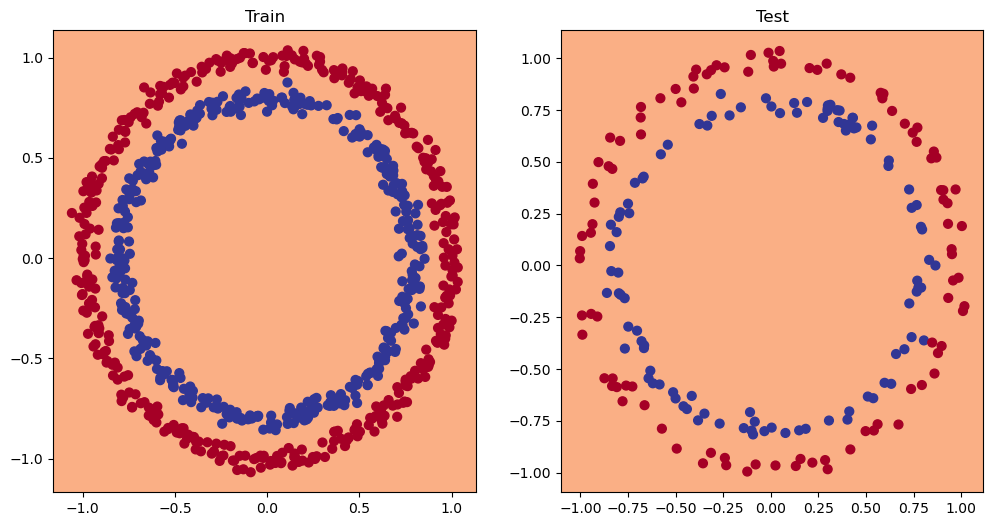

In [69]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0,
                       X_train,
                       y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0,
                       X_test,
                       y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units. 
* Fit for longer more epochs
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.
And because these options are all values we as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
• Adding more hidden units: 5 > 10
• Increase the number of layers: 2 > 3
• Increase the number of epochs: 100 > 1000

In [70]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))
    

In [71]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [72]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [73]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [74]:
# Write a training and evaluation loop for model_1
# Set for reproducibility
torch.manual_seed(42)

# Train for longer epochs
epochs = 1000

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training Phase ###
    model_1.train()

    # 1. Forward pass with raw logits from the model
    y_logits = model_1(X_train).squeeze() # squeeze() removes any extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> prediction probability -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCEWithLogitsLoss expects raw logits as input e.g. y_logits    
    
    # 3. Calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 4. Optimizer zero grad also known as zero the gradients
    optimizer.zero_grad()

    # 5. Loss backwards backpropagation
    loss.backward()

    # 6. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass with raw logits from the model
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    # Print out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72476, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.72452, Acc: 50.50% | Test loss: 0.69258, Test acc: 50.00%
Epoch: 20 | Loss: 0.72427, Acc: 50.25% | Test loss: 0.69258, Test acc: 50.50%
Epoch: 30 | Loss: 0.72403, Acc: 49.75% | Test loss: 0.69259, Test acc: 50.00%
Epoch: 40 | Loss: 0.72379, Acc: 49.62% | Test loss: 0.69261, Test acc: 50.00%
Epoch: 50 | Loss: 0.72355, Acc: 48.88% | Test loss: 0.69265, Test acc: 48.50%
Epoch: 60 | Loss: 0.72332, Acc: 48.75% | Test loss: 0.69270, Test acc: 49.50%
Epoch: 70 | Loss: 0.72308, Acc: 48.25% | Test loss: 0.69277, Test acc: 49.50%
Epoch: 80 | Loss: 0.72285, Acc: 47.75% | Test loss: 0.69286, Test acc: 49.00%
Epoch: 90 | Loss: 0.72261, Acc: 47.12% | Test loss: 0.69296, Test acc: 49.00%
Epoch: 100 | Loss: 0.72238, Acc: 46.25% | Test loss: 0.69307, Test acc: 48.00%
Epoch: 110 | Loss: 0.72215, Acc: 45.00% | Test loss: 0.69320, Test acc: 46.00%
Epoch: 120 | Loss: 0.72193, Acc: 41.38% | Test loss: 0.69334, T

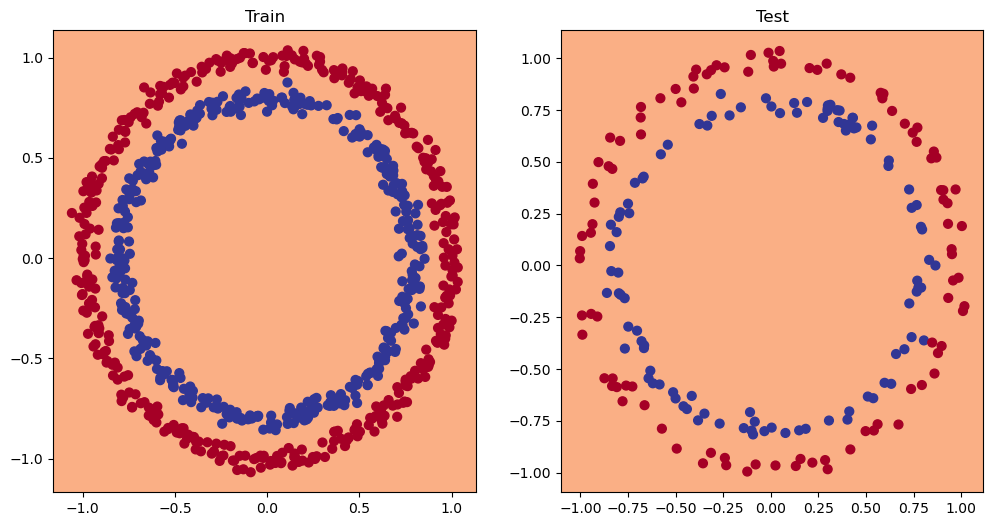

In [75]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1,
                       X_train,
                       y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1,
                       X_test,
                       y_test)

### 5.1 Preparing data to see if our model can fit a straight line
One way to troubleshoot to a larger problem is to test out a smaller problem.|

In [76]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check out the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [77]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data for training
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

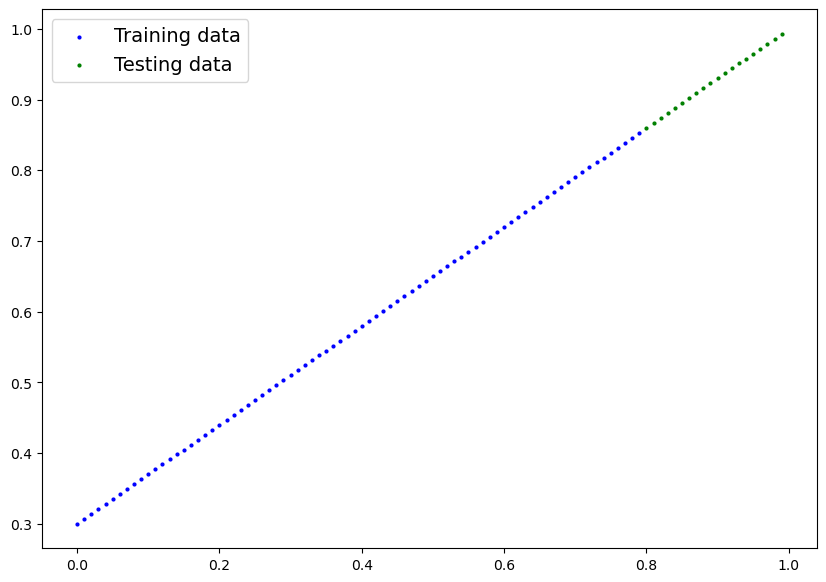

In [78]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

### 5.2 Adjusting model_1' to fit a straight line

In [79]:
# Same architecture as model_1 (but using nn.Sequential ())
model_2 = nn.Sequential(nn.Linear(in_features=1, out_features=10),
                        nn.Linear(in_features=10, out_features=10),
                        nn.Linear(in_features=10, out_features=1)).to(device)                       

In [80]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [83]:
# Train the model
torch.manual_seed(42)

# Set the number of training epochs or training loops
epochs = 1000

# Put the data to the target device (cpu)
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training Phase ###
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

        # Print out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.01460, Test loss: 0.00257
Epoch: 10 | Loss: 0.01453, Test loss: 0.00269
Epoch: 20 | Loss: 0.01499, Test loss: 0.00281
Epoch: 30 | Loss: 0.01471, Test loss: 0.00235
Epoch: 40 | Loss: 0.01391, Test loss: 0.00234
Epoch: 50 | Loss: 0.01510, Test loss: 0.00306
Epoch: 60 | Loss: 0.01482, Test loss: 0.00257
Epoch: 70 | Loss: 0.01454, Test loss: 0.00212
Epoch: 80 | Loss: 0.01500, Test loss: 0.00268
Epoch: 90 | Loss: 0.01441, Test loss: 0.00280
Epoch: 100 | Loss: 0.01486, Test loss: 0.00292
Epoch: 110 | Loss: 0.01511, Test loss: 0.00290
Epoch: 120 | Loss: 0.01504, Test loss: 0.00302
Epoch: 130 | Loss: 0.01497, Test loss: 0.00314
Epoch: 140 | Loss: 0.01469, Test loss: 0.00266
Epoch: 150 | Loss: 0.01441, Test loss: 0.00220
Epoch: 160 | Loss: 0.01435, Test loss: 0.00275
Epoch: 170 | Loss: 0.01358, Test loss: 0.00276
Epoch: 180 | Loss: 0.01454, Test loss: 0.00242
Epoch: 190 | Loss: 0.01499, Test loss: 0.00300
Epoch: 200 | Loss: 0.01419, Test loss: 0.00251
Epoch: 210 | Loss: 0.014

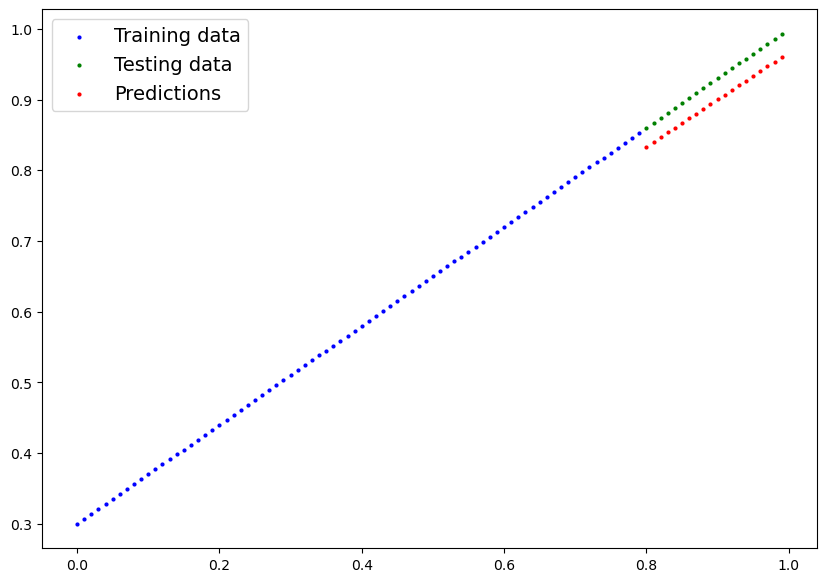

In [84]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference mode)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression, 
                 test_data=X_test_regression, 
                 test_labels=y_test_regression, 
                 predictions=y_preds)